In [1]:
import numpy as np
import matplotlib.pylab as plt
import corner
import numdifftools as nd
import glob
import scipy.optimize as so
import scipy.linalg as sl
from PTMCMCSampler import PTMCMCSampler

%matplotlib inline

Do not have acor package


In [2]:
class CurvedLikelihood(object):
    
    def __init__(self):
        
        self.pmin = np.array([-10, -10])
        self.pmax = np.array([10, 10])
    
    def lnlikefn(self, x):
        
        # x = x[0],  y = x[1]
        
        ll = np.exp(-x[0]**2 - (9+4*x[0]**2 + 9*x[1])**2) + 0.5 * np.exp(-8*x[0]**2-8*(x[1]-2)**2)
        
        return np.log(ll)
    
    def lnlikefn_grad(self, x):
        
        # x = x[0],  y = x[1]
        ll_grad = np.zeros_like(x)
        ll_0_grad = np.zeros_like(x)
        ll_1_grad = np.zeros_like(x)
        
        # Likelihood components
        ll_0 = -x[0]**2 - (9+4*x[0]**2 + 9*x[1])**2
        ll_1 = -8*x[0]**2-8*(x[1]-2)**2
        
        # Gradients for component 0
        ll_0_grad[0] = -2.0*x[0] - 2.0*(9+4*x[0]**2+9*x[1])*(8*x[0])
        ll_0_grad[1] = -18.0*(9+4*x[0]**2+9*x[1])
        
        # Gradients for component 1
        ll_1_grad[0] = -16*x[0]
        ll_1_grad[1] = -16*(x[1]-2)
        
        # Combined likelihood
        lik = np.exp(ll_0) + 0.5 * np.exp(ll_1)
        
        # Combined gradients
        ll_grad = (np.exp(ll_0) * ll_0_grad + 0.5*np.exp(ll_1) * ll_1_grad) / lik
        
        return np.log(lik), ll_grad
    
    def lnpriorfn(self, x):
        
        if np.all(self.pmin < x) and np.all(self.pmax > x):
            return 0.0
        else:
            return -np.inf  
        return 0.0
    
    def lnpriorfn_grad(self, x):
        return self.lnpriorfn(x), np.zeros_like(x)

cl = CurvedLikelihood()

In [3]:
# Demonstrate that the gradients are accurate
p0 = np.array([-0.1, -0.5]) # np.array([-0.07943648, -0.63131195]) # np.random.randn(2)
ndjac = nd.Jacobian(cl.lnlikefn)
ndhess = nd.Hessian(cl.lnlikefn)

print(p0)
print(cl.lnlikefn_grad(p0)[1])
print(ndjac(p0))

[-0.1 -0.5]
[  7.464 -81.72 ]
[[  7.464 -81.72 ]]


In [4]:
result = so.minimize(lambda x: -cl.lnlikefn(x), p0, jac=lambda x: -cl.lnlikefn_grad(x)[1],
                     method='Newton-CG', hess=lambda x: -ndhess(x), options={'disp':True})

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 8


In [5]:
# Start position & covariance based on ML & Hessian (for Hessian, use stepsize = 0.045)
p0 = result['x']
h0 = ndhess(p0)
cov = sl.cho_solve(sl.cho_factor(-h0), np.eye(len(h0)))

# Hessian not the best option for this multi-modal problem. Use custom value:
cov = np.diag([1.0, 1.0])

In [6]:
sampler = PTMCMCSampler.PTSampler(2, cl.lnlikefn, cl.lnpriorfn, np.copy(cov),
                                  logl_grad=cl.lnlikefn_grad, logp_grad=cl.lnpriorfn_grad,
                                  outDir='./chains')

In [7]:
sampler.sample(p0, 100000, burn=10000, thin=1,
               SCAMweight=10, AMweight=10, DEweight=10, NUTSweight=10, HMCweight=10, MALAweight=0,
               HMCsteps=50, HMCstepsize=0.08)

<ipython-input-2-3d5fa0b8f203>:14: RuntimeWarning: divide by zero encountered in log
  return np.log(ll)


Finished 1.00 percent in 0.892365 s Acceptance rate = 0.475

<ipython-input-2-3d5fa0b8f203>:39: RuntimeWarning: invalid value encountered in true_divide
  ll_grad = (np.exp(ll_0) * ll_0_grad + 0.5*np.exp(ll_1) * ll_1_grad) / lik
<ipython-input-2-3d5fa0b8f203>:41: RuntimeWarning: divide by zero encountered in log
  return np.log(lik), ll_grad


Finished 10.00 percent in 7.842672 s Acceptance rate = 0.55357Adding DE jump with weight 10
Finished 99.00 percent in 61.073244 s Acceptance rate = 0.483172
Run Complete


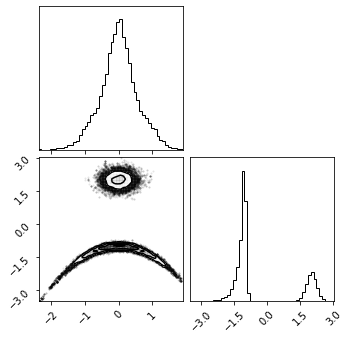

In [8]:
data = np.loadtxt('chains/chain_1.txt')
corner.corner(data[:,:2], bins=50);

(0.0, 1.1)

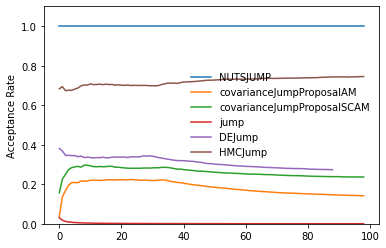

In [9]:
jumpfiles = glob.glob('chains/*jump.txt')
jumps = map(np.loadtxt, jumpfiles)
for ct, j in enumerate(jumps):
    plt.plot(j, label=jumpfiles[ct].split('/')[-1].split('_jump.txt')[0])
plt.legend(loc='best', frameon=False)
plt.ylabel('Acceptance Rate')
plt.ylim(0.0, 1.1)